In [1]:
%reload_ext autoreload
%autoreload 1
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
import functions.data_manipulation_functions as dmf
import functions.plot_functions as pf
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
%aimport functions.transformers
%aimport functions.data_manipulation_functions
%aimport functions.plot_functions

In [2]:
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

In [3]:
data_accepted=pl.read_csv('data/accepted_2007_to_2018Q4.csv',dtypes={'id':str})

In [4]:
data_accepted['id'].is_duplicated().any()

False

In [5]:
data_rejected=pl.read_csv('data/rejected_2007_to_2018Q4.csv')

In [6]:
data_rejected.shape

(27648741, 9)

In [7]:
data_accepted.shape

(2260701, 151)

In [8]:
data_rejected.head()

Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
f64,str,str,f64,str,str,str,str,f64
1000.0,"""2007-05-26""","""Wedding Covere…",693.0,"""10%""","""481xx""","""NM""","""4 years""",0.0
1000.0,"""2007-05-26""","""Consolidating …",703.0,"""10%""","""010xx""","""MA""","""< 1 year""",0.0
11000.0,"""2007-05-27""","""Want to consol…",715.0,"""10%""","""212xx""","""MD""","""1 year""",0.0
6000.0,"""2007-05-27""","""waksman""",698.0,"""38.64%""","""017xx""","""MA""","""< 1 year""",0.0
1500.0,"""2007-05-27""","""mdrigo""",509.0,"""9.43%""","""209xx""","""MD""","""< 1 year""",0.0


### Join procedure

In [9]:
data_accepted = data_accepted.with_columns(pl.lit(np.int8(1)).alias('policy_code'))

In [10]:
data_rejected = data_rejected.with_columns(pl.lit(np.int8(0)).alias('Policy Code'))

In [11]:
data_rejected = data_rejected.with_columns(
    data_rejected["Debt-To-Income Ratio"]
    .map_elements(lambda x: np.float32(x.rstrip("%")))
    .alias("Debt-To-Income Ratio")
)

In [12]:
data_full = pl.concat(
    [
        data_rejected.select(
            pl.col("Amount Requested"),
            pl.col("Loan Title"),
            pl.col("Debt-To-Income Ratio"),
            pl.col("Zip Code"),
            pl.col("State"),
            pl.col("Employment Length"),
            pl.col("Policy Code"),
        ),
        data_accepted.select(
            pl.col('loan_amnt').alias("Amount Requested"),
            pl.col('title').alias("Loan Title"),
            pl.col('dti').alias("Debt-To-Income Ratio"),
            pl.col('zip_code').alias("Zip Code"),
            pl.col('addr_state').alias("State"),
            pl.col('emp_length').alias("Employment Length"),
            pl.col('policy_code').alias("Policy Code"),
        ),
    ]
)

In [13]:
data_full.null_count()

Amount Requested,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
u32,u32,u32,u32,u32,u32,u32
33,24661,1744,327,55,1098295,0


In [14]:
data_full.head()

Amount Requested,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
f64,str,f64,str,str,str,i32
1000.0,"""Wedding Covere…",10.0,"""481xx""","""NM""","""4 years""",0
1000.0,"""Consolidating …",10.0,"""010xx""","""MA""","""< 1 year""",0
11000.0,"""Want to consol…",10.0,"""212xx""","""MD""","""1 year""",0
6000.0,"""waksman""",38.639999,"""017xx""","""MA""","""< 1 year""",0
1500.0,"""mdrigo""",9.43,"""209xx""","""MD""","""< 1 year""",0


#### Splits

# stop here

In [19]:
category_mappings = {
    "credit_card": ["credit_card"],
    "car": ["car"],
    "debt_consolidation": ["consolid", "refinan", "debt"],
    "medical": ["medic"],
    "business": ["business"],
    "moving": ["moving", "relocation"],
    "home": ["home", "house"],
    "education": ["educ", "school", "stud", "university"],
    "green_loan": ["renew"],
}

category_mappings_is = {None: ["_", "other"]}


In [20]:
def text_preprocessing_wo_training(df):
    df = (
        df
        .pipe(dmf.lowercase_underscore_text, 'Loan Title', 'title')
        .pipe(dmf.text_contains_numbers, 'title')
        .pipe(dmf.text_length, 'title')
        .pipe(dmf.starts_with_lowercase, 'title')
        .pipe(dmf.categorize_strings_contains, category_mappings, 'title')
        .pipe(dmf.categorize_strings_is, category_mappings_is, 'title')
        .pipe(dmf.drop_column,'Loan Title')
        .pipe(dmf.replace_below_min,"Amount Requested", 1, None)
        .pipe(dmf.replace_below_min, "Debt-To-Income Ratio", 0, None)
    )
    return df

# Apply the custom procedure to your DataFrame
data_full = text_preprocessing_wo_training(data_full)


In [21]:
title_imputer=tr.NotInImputerPolars(fill_value=None,cat_no=12)

In [25]:
data_full=data_full.with_columns(title_imputer.fit_transform(data_full['title'].alias('title')))

In [26]:
data_full['title'].value_counts()

title,counts
str,u32
"""major_purchase…",1002503
"""moving""",717259
"""business""",888105
"""green_loan""",58183
"""home""",2033385
"""debt_consolida…",13576475
"""car""",5492655
null,5010293
"""vacation""",323848


In [27]:
null_counts=data_full.null_count()/len(data_full)
for col in null_counts.columns:
    null_counts=null_counts.with_columns(pl.col(col).map_elements(lambda x: f'{x:.2f}%').alias(col))
null_counts

Amount Requested,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code,title,title_contains_numbers,title_length,title_starts_with_lowercase
str,str,str,str,str,str,str,str,str,str
"""0.00%""","""0.04%""","""0.00%""","""0.00%""","""0.04%""","""0.00%""","""0.17%""","""0.00%""","""0.00%""","""0.00%"""


In [28]:
data_full.describe()

describe,Amount Requested,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code,title,title_contains_numbers,title_length,title_starts_with_lowercase
str,f64,f64,str,str,str,f64,str,f64,f64,f64
"""count""",2.9909442e7,2.9909442e7,"""29909442""","""29909442""","""29909442""",2.9909442e7,"""29909442""",2.9909442e7,2.9909442e7,2.9909442e7
"""null_count""",1321.0,1.204809e6,"""327""","""55""","""1098295""",0.0,"""5010293""",24661.0,24661.0,24661.0
"""mean""",13278.456233,139.590639,null,null,null,0.075585,null,0.000509,14.622679,0.99934
"""std""",14659.548401,10343.523853,null,null,null,0.264333,null,0.02256,6.035606,0.025685
"""min""",25.0,0.0,"""000xx""","""AK""","""1 year""",0.0,"""business""",0.0,1.0,0.0
"""25%""",5000.0,10.0,null,null,null,0.0,null,null,11.0,null
"""50%""",10000.0,20.610001,null,null,null,0.0,null,null,18.0,null
"""75%""",20000.0,35.990002,null,null,null,0.0,null,null,18.0,null
"""max""",1.4e6,5.0000032e7,"""999xx""","""WY""","""< 1 year""",1.0,"""wedding""",1.0,3572.0,1.0


In [29]:
len(data_full.filter(data_full['Debt-To-Income Ratio']==9999))

76984

In [30]:
data_full.filter(data_full['Debt-To-Income Ratio']!=9999)['Debt-To-Income Ratio'].max()

50000032.0

In [31]:
data_full = data_full.with_columns(
    pl.col("Debt-To-Income Ratio")
    .map_elements(lambda x: 100 if x == 9999 else x)
    .alias("Debt-To-Income Ratio")
)

In [32]:
data_full.filter(data_full['Debt-To-Income Ratio']!=100)['Debt-To-Income Ratio'].max()

50000032.0

In [33]:
data_full = data_full.with_columns(
    pl.col("Debt-To-Income Ratio")
    .map_elements(lambda x: 5 if x == 100 else x)
    .alias("Debt-To-Income Ratio")
)

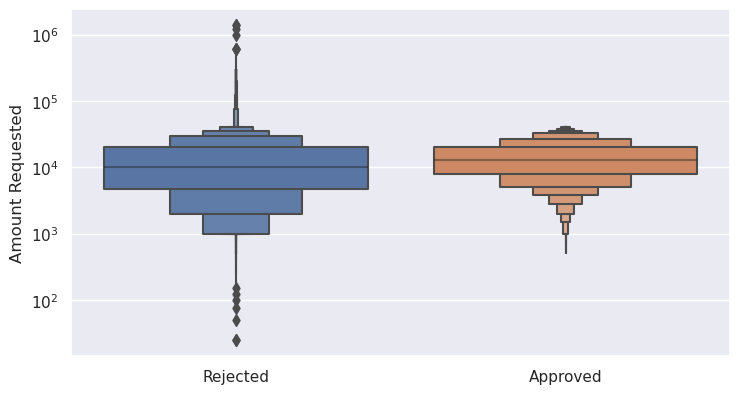

In [34]:
fig_requested_box, ax_requested_box = plt.subplots(figsize=BASE_FIG_SIZE)
sns.boxenplot(
    x=data_full.select(["Amount Requested", "Policy Code"]).drop_nulls()['Policy Code'].to_numpy(),
    y=data_full.select(["Amount Requested", "Policy Code"]).drop_nulls()["Amount Requested"].to_numpy(),
    ax=ax_requested_box
)
ax_requested_box.set_yscale("log")
ax_requested_box.set_ylabel("Amount Requested")
ax_requested_box.set_xticklabels(('Rejected','Approved'))
plt.show()

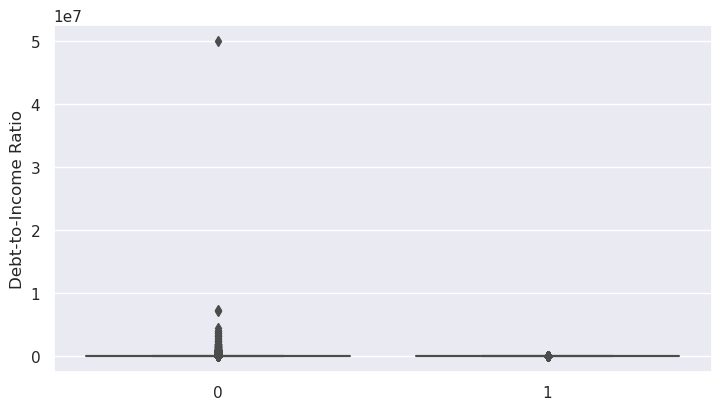

In [35]:
fig_dti_box, ax_dti_box = plt.subplots(figsize=BASE_FIG_SIZE)
sns.boxplot(
    x=data_full.select(["Debt-To-Income Ratio", "Policy Code"])
    .drop_nulls()["Policy Code"]
    .to_numpy(),
    y=data_full.select(["Debt-To-Income Ratio", "Policy Code"])
    .drop_nulls()["Debt-To-Income Ratio"]
    .to_numpy(),
    ax=ax_dti_box,
)

# ax_dti_box.set_yscale("log")
ax_dti_box.set_ylabel("Debt-to-Income Ratio")
plt.show()

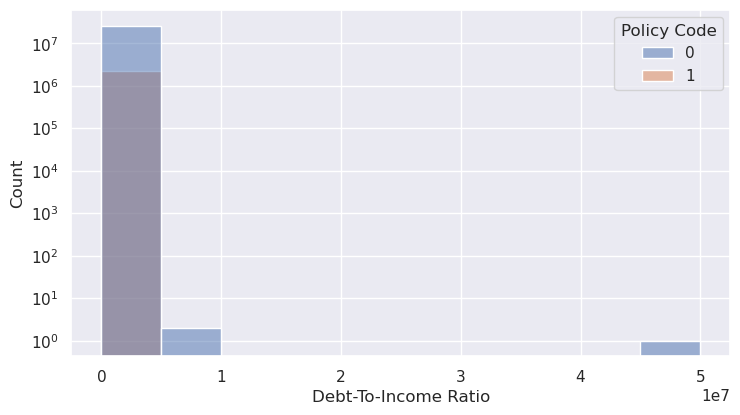

In [36]:
fig_dti_hist, ax_dti_hist = plt.subplots(figsize=BASE_FIG_SIZE)
sns.histplot(
    x=data_full.select(["Debt-To-Income Ratio", "Policy Code"]).drop_nulls()[
        "Debt-To-Income Ratio"
    ],
    hue=data_full.select(["Debt-To-Income Ratio", "Policy Code"]).drop_nulls()[
        "Policy Code"
    ],
    bins=10,
    ax=ax_dti_hist
)
plt.yscale("log")

In [37]:
state_counts=data_full.group_by('State').agg(
    pl.count().alias('Application Count'),
    (pl.sum('Policy Code')/pl.count()*100).alias('Accepted Percentage')
)

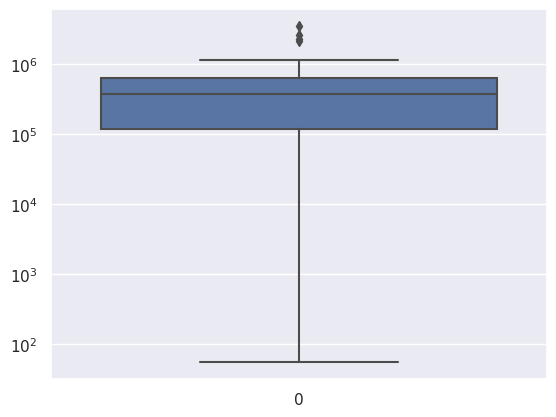

In [38]:
sns.boxplot(state_counts['Application Count'])
plt.yscale('log')

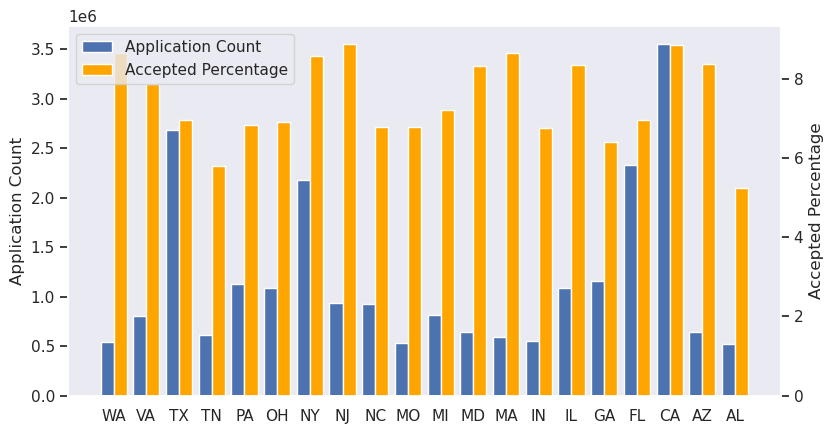

In [41]:
fig_state_counts, ax_state_counts = pf.plot_grouped_bars(
    state_counts, return_fig=True, top_vals=20,figsize_args={'figsize':BASE_FIG_SIZE}
)

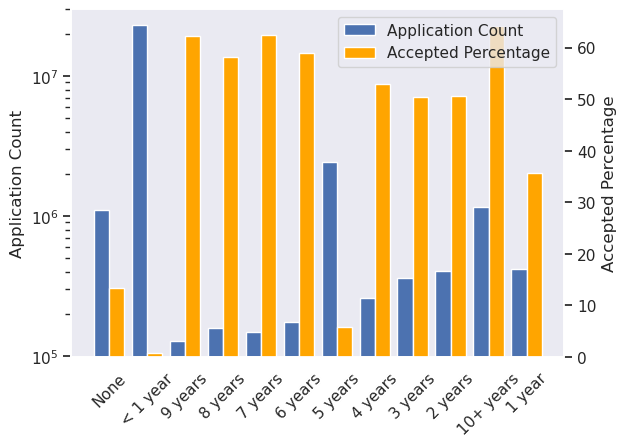

In [46]:
work_time_counts = data_full.group_by("Employment Length").agg(
    pl.count().alias("Application Count"),
    (pl.sum("Policy Code") / pl.count() * 100).alias("Accepted Percentage"),
)
work_time_counts = work_time_counts.fill_null("None")

fig_emp_length, ax_empl_length = pf.plot_grouped_bars(
    work_time_counts, x_label_args={"rotation": 45}, return_fig=True
)

ax_empl_length[0].set_yscale('log')

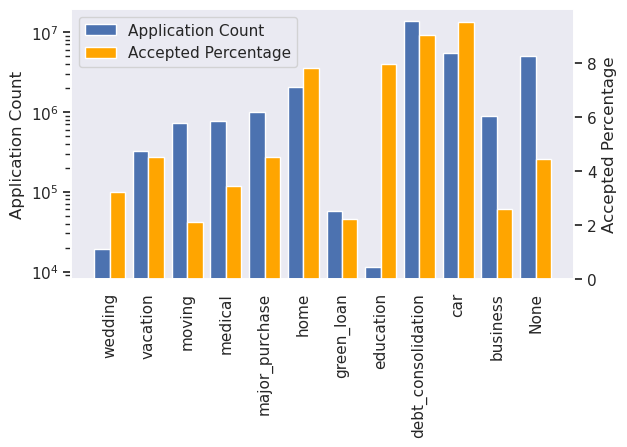

In [50]:
title_counts = data_full.group_by("title").agg(
    pl.count().alias("Application Count"),
    (pl.sum("Policy Code") / pl.count() * 100).alias("Accepted Percentage"),
)
title_counts = title_counts.fill_null("None")

fig_title, ax_title = pf.plot_grouped_bars(
    title_counts, x_label_args={"rotation": 90}, return_fig=True
)

ax_title[0].set_yscale('log')

### Splits

In [51]:
class_imbalance = (
    data_full["Policy Code"].value_counts()["counts"][1]
    / data_full["Policy Code"].value_counts()["counts"][0]
)
round(class_imbalance,3)

0.082

In [56]:
data_full_train, data_full_test= train_test_split(
    data_full,
    test_size=0.4,
    stratify=data_full["Policy Code"],
)

In [58]:
data_full_val, data_full_test = train_test_split(
    data_full_test, stratify=data_full_test["Policy Code"], random_state=1
)

In [68]:
data_sample = train_test_split(data_full_train,
    stratify=data_full_train["Policy Code"],
    test_size=2,
    train_size=50000,
    random_state=1,
)
data_sample=data_sample[0]

In [70]:
data_sample.write_parquet('data/data_sample.parquet')
